In [1]:
#라이브러리 import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import normal
from pandas import Series, DataFrame
from numpy.random import normal

In [2]:
#------------#
# Parameters #
#------------#

N=10            # 샘플을 취득하는 위치 x의 개수
M=[0,1,3,9]     # 그래프로 표현할 다항식의 차수

In [3]:
# 데이터 셋 생성 함수 만들기
def create_dataset(num):
    dataset = DataFrame(columns=['x','y'])
    for i in range(num):
        x = float(i)/float(num-1)
        y = np.sin(2*np.pi*x) + normal(scale = 0.3) #add error
        dataset = dataset.append(Series([x,y],index=('x','y')),
                                 ignore_index = True)
    return dataset

In [4]:
# 데이터 셋 생성
train_set = create_dataset(N)
test_set = create_dataset(N)

     x     y
0 0.00  0.21
1 0.11  0.24
2 0.22  0.82
3 0.33  0.72
4 0.44  0.40
5 0.56 -0.86
6 0.67 -1.09
7 0.78 -0.66
8 0.89 -0.45
9 1.00  0.10


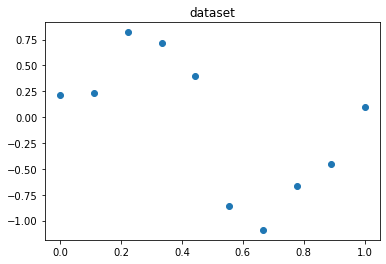

In [12]:
# 데이터 출력
df_ws = DataFrame()

X = train_set['x']
Y = train_set['y']

plt.scatter(X,Y)
plt.title('dataset')

print(train_set)

In [13]:
# 최소 제곱법으로 계산하기 (다항식의 w값을 찾기)

# w: (M+1,1) matrix
# phi: (N,M+1) matrix
# wT * phiT * phi - tT * phi = 0
# w = inv(phiT * phi) * phiT * t

def resolve(dataset, m):
    t = dataset.y
    phi = DataFrame()
    
    for i in range(0,m+1):
        p = dataset.x**i
        p.name="x**%d" % i
        phi = pd.concat([phi,p], axis=1)
    tmp = np.linalg.inv(np.dot(phi.T, phi))
    ws = np.dot(np.dot(tmp, phi.T), t)

    # 다항식 근사 계산 함수
    def f(x):
        y = 0
        for i, w in enumerate(ws):
            y += w * (x ** i)
        return y

    return (f, ws)

In [14]:
# w matrix 구하기(다항식 차수에 따른 w 값들)

df_ws = DataFrame()

for c, m in enumerate(range(0,N)):
    f, ws = resolve(train_set, m)
    df_ws = df_ws.append(Series(ws,name="M=%d" % m))

pd.options.display.float_format = "{:,.2f}".format
print("Table of the coefficients")
df_ws.transpose()

Table of the coefficients


,M=0,M=1,M=2,M=3,M=4,M=5,M=6,M=7,M=8,M=9
0,-0.06,0.48,0.68,0.05,0.04,0.20,0.22,0.21,0.21,0.21
1,NaN,-1.09,-2.40,7.91,8.32,-5.64,-13.38,3.32,-19.08,-135.07
2,NaN,NaN,1.31,-25.86,-27.93,88.45,183.98,-91.58,360.07,"3,039.32"
3,NaN,NaN,NaN,18.12,21.44,-307.53,-718.70,915.43,"-2,491.19","-26,624.30"
4,NaN,NaN,NaN,NaN,-1.66,375.42,"1,169.99","-3,450.61","9,400.67","122,775.44"
5,NaN,NaN,NaN,NaN,NaN,-150.83,-857.62,"5,880.56","-20,874.58","-329,751.18"
6,NaN,NaN,NaN,NaN,NaN,NaN,235.60,"-4,654.35","26,559.99","532,329.19"
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1,397.13","-17,713.69","-508,280.58"
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,777.70","264,324.31"
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"-57,677.23"


In [15]:
# 제곱근 평균 제곱 오차(Root mean square error) 계산 함수
def rms_error(dataset, f):
    err = 0.0
    # x value: line.x  y value: line.y
    for index, line in dataset.iterrows():
        x, y = line.x, line.y
        err += 0.5 * (y - f(x))**2
    return np.sqrt(2 * err / len(dataset))

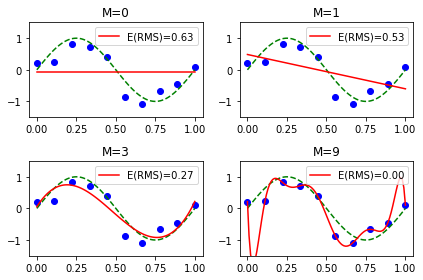

In [16]:
# 다항식 그래프로 표시

fig = plt.figure()

for c, m in enumerate(M):
    f, ws = resolve(train_set, m)
    df_ws = df_ws.append(Series(ws,name="M=%d" % m))


    
    subplot = fig.add_subplot(2,2,c+1)
    subplot.set_xlim(-0.05,1.05)
    subplot.set_ylim(-1.5,1.5)
    subplot.set_title("M=%d" % m)

    # 트레이닝 세트 표시
    subplot.scatter(train_set.x, train_set.y, marker='o', color='blue')

    # sin곡선을 표시
    linex = np.linspace(0,1,101)
    liney = np.sin(2*np.pi*linex)
    subplot.plot(linex, liney, color='green', linestyle='--')

    # 근사 곡선 표시
    linex = np.linspace(0,1,101)
    liney = f(linex)
    
    # error값 표시
    label = "E(RMS)=%.2f" % rms_error(train_set, f)
    subplot.plot(linex, liney, color='red', label=label)
    subplot.legend(loc=1)

fig.tight_layout()

<AxesSubplot:title={'center':'RMS Error'}>

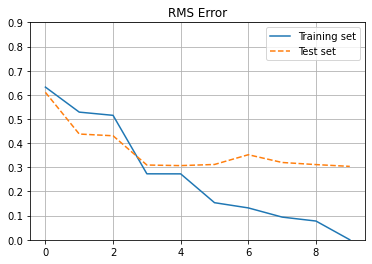

In [11]:
# 트레이닝 세트와 테스트 세트 오차 차이
df = DataFrame(columns=['Training set','Test set'])
for m in range(0,10):
    f, ws = resolve(train_set, m)
    train_error = rms_error(train_set, f)
    test_error = rms_error(test_set, f)
    df = df.append(
            Series([train_error, test_error],
                index=['Training set','Test set']),
            ignore_index=True)
df.plot(title='RMS Error', style=['-','--'], grid=True, ylim=(0,0.9))